## Experiments

In [1]:
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt

In [2]:
modalities = ["car", "shared-car", "public-transport", "bike"]

series_reporters = [
    *[f"monthly-{m}-trips" for m in modalities],
    "count cars",
    "shared-car-subscriptions",
    "public-transport-subscriptions",
]

single_reporters = []

In [3]:
replications = 10
months = 60
exp_nr = 0

# exp_names = ["8-sc-default", "32-sc-22-pp-20p-removed", "128-sc-93-pp-40p-removed"]
exp_names = ["default", "remove-spots-low", "remove-spots-high"]
plot_name = "remove_spots"
exp_names = [f"{i}_{name}" for i, name in enumerate(exp_names)]
print(exp_names)

['0_default', '1_remove-spots-low', '2_remove-spots-high']


In [4]:
# Read all the pickles into a dictionary of dataframes
dfs = {}
for i, name in enumerate(exp_names):
    dfs[name] = pd.read_pickle(f"../results/experiments/exp_series_{name}_{replications}r_df.pickle")

In [5]:
KPIs = series_reporters

df_end = {}
for KPI in KPIs:
    df_end[KPI] = pd.DataFrame()
    for name, df in dfs.items():
        df_end[KPI][name] = df.iloc[months][KPI]
df_end["count cars"].head(3)

,0_default,1_remove-spots-low,2_remove-spots-high
0,1083.0,1052.0,861.0
1,1067.0,1081.0,782.0
2,1047.0,1061.0,861.0


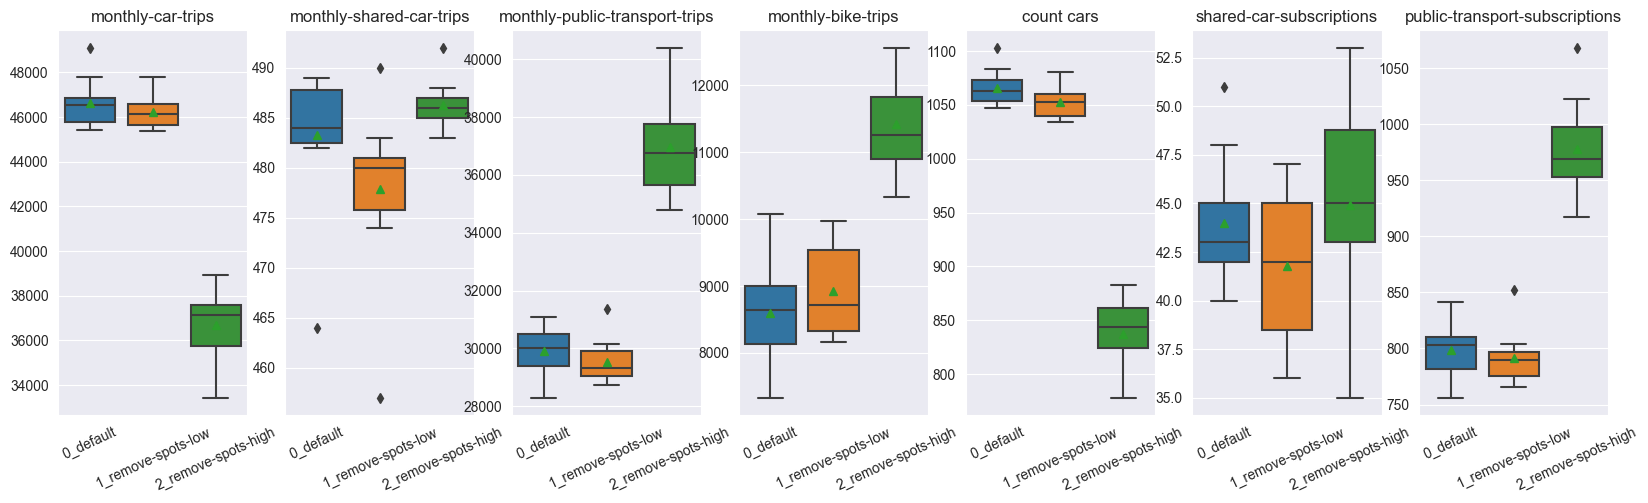

In [6]:
fig, axes = plt.subplots(1,len(KPIs))
fig.set_size_inches(20,5)
g = {}
for i, KPI in enumerate(KPIs):
    g[KPI] = sns.boxplot(df_end[KPI], showmeans=True, ax=axes[i])
    g[KPI].set_xticklabels(g[KPI].get_xticklabels(), rotation=25)
    g[KPI].set_title(KPI)
    # g[KPI].set_ylabel("Residents")
fig.savefig("../images/exp_test_boxplots.svg")

### Dynamics

In [7]:
# Create an empty DataFrame for each KPI
dy_dict = {}
for KPI in KPIs:
    dy_dict[KPI] = pd.DataFrame()

# For each experiment, add a data column to the dataframe of each KPI
for i, exp in enumerate(exp_names):
    df_t = dfs[exp].sort_index(axis="columns", level=0)
    for KPI in KPIs:
        dy_dict[KPI][exp] = df_t[KPI].unstack()
dy_dict[KPIs[0]].head()

0_default 1_remove-spots-low 2_remove-spots-high
0 0.0       0.0                0.0                 0.0
  1.0   52783.0            51480.0             51059.0
  2.0   52324.0            50854.0             50515.0
  3.0   51879.0            50604.0             49912.0
  4.0   51477.0            50283.0             49599.0

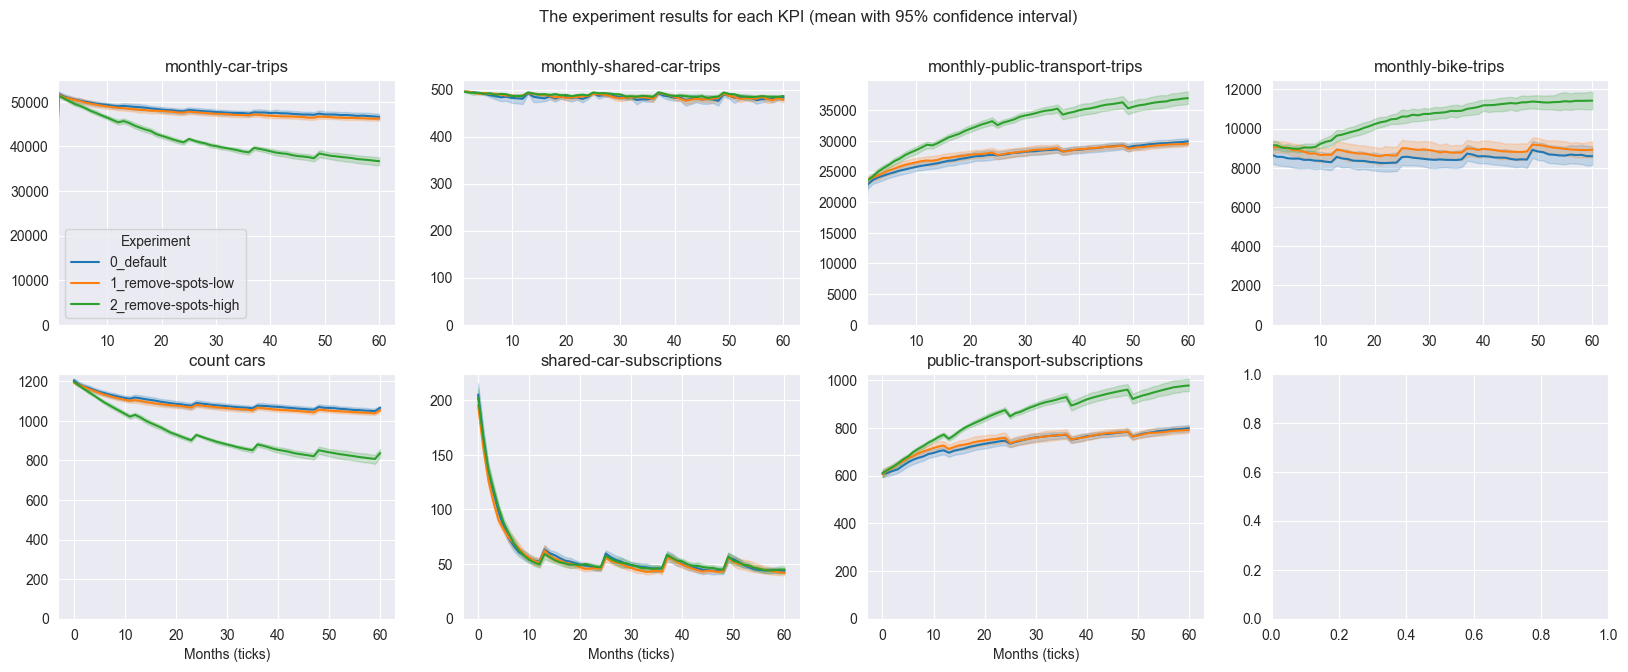

In [8]:
# Plot a lineplot for each KPI with seaborn
# This cell takes a long time, 2 to 3 minutes (probably because of the confidence interval calculation
to_plot = True # Set True to run this complicated plot
if to_plot:
    # Create a figure and axis
    fig, axes = plt.subplots(2,4)
    fig.set_size_inches(20,7)

    g = {}
    for i, KPI in enumerate(KPIs):
        # Unstack the dataframe for each KPI, and rename the columns
        df_t = dy_dict[KPI].T.unstack().reset_index()
        df_t.columns = ["Reps", "Ticks", "Experiment", "Data"]

        # Create the lineplot with confidence intervals and save as SVG
        g[KPI] = sns.lineplot(df_t, x="Ticks", y="Data", hue="Experiment", errorbar=("ci", 95), ax=axes.flat[i])
        g[KPI].set_title(f"{KPI}")
        g[KPI].set_ylim(bottom=0)
        # Set xlabel for the bottom row
        if i >= 4:
            g[KPI].set_xlabel("Months (ticks)")
        else:
            g[KPI].set_xlabel("")
        g[KPI].set_ylabel("")
        # Remove the legend except the fourth plot
        if i != 0:
            g[KPI].legend_.remove()
        # Drop the first row for all the trip KPIs, since in month 0 no trips have been made
        if i <= 3:
            g[KPI].set_xlim(left=1)
    fig.suptitle("The experiment results for each KPI (mean with 95% confidence interval)")
    fig.savefig(f"../images/exp_{plot_name}_lineplots.svg")

### Streets spotted

In [9]:
KPI = "shared-car-subscriptions"
df_spotted = pd.DataFrame()

# For each experiment, add a data column to the dataframe of each KPI
for i, exp in enumerate(exp_names):
    df_t = dfs[exp].sort_index(axis="columns", level=0)
    df_spotted[exp] = df_t[KPI].unstack()
df_spotted.head()

0_default 1_remove-spots-low 2_remove-spots-high
0 0.0     185.0              199.0               181.0
  1.0     149.0              172.0               145.0
  2.0     120.0              141.0               123.0
  3.0     105.0              118.0               115.0
  4.0      83.0              101.0                99.0

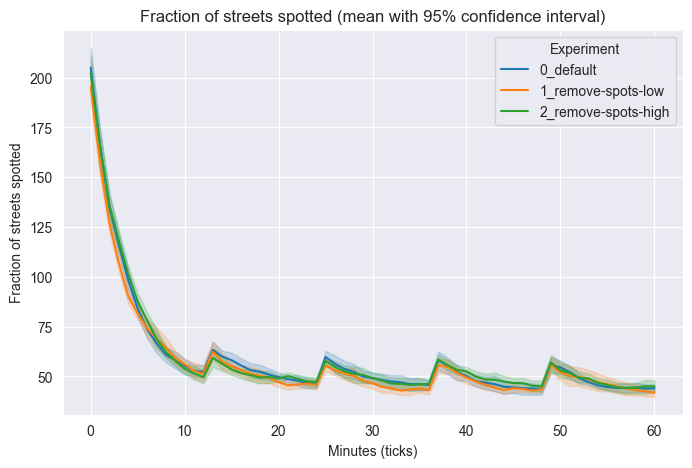

In [10]:
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(8,5)

df_t = df_spotted.T.unstack().reset_index()
df_t.columns = ["Reps", "Ticks", "Experiment", "Data"]

# Create the lineplot with confidence intervals and save as SVG
gs = sns.lineplot(df_t, x="Ticks", y="Data", hue="Experiment", errorbar=("ci", 95), ax=ax1)

gs.set_title(f"Fraction of streets spotted (mean with 95% confidence interval)")
gs.set_ylabel("Fraction of streets spotted")
gs.set_xlabel("Minutes (ticks)")
fig.savefig("../images/exp_spotted_lineplots.svg")